#Examples of single and multi-head

In [ ]:
import matplotlib.pyplot as plt
import torch
import math

In [ ]:
torch.manual_seed(42)
x = torch.rand(1, 5, 8)

In [ ]:
qry_proj = torch.nn.Linear(8, 8)
key_proj = torch.nn.Linear(8, 8)
val_proj = torch.nn.Linear(8, 8)

qry = qry_proj(x)
key = key_proj(x)
val = val_proj(x)

# qry -> (1, 5, 8)
# key -> (1, 5, 8)
# val -> (1, 5, 8)

# att -> (1, 5, 8) @ (1, 8, 5) = (1, 5, 5)
# out -> (1, 5, 5) @ (1, 5, 8) = (1, 5, 8)

att = qry @ key.transpose(-1, -2) / math.sqrt(8)
msk = torch.tril(torch.ones(5, 5)) == 0
att = att.masked_fill(msk, -float('inf'))
att = torch.softmax(att, dim=-1)
out = att @ val

<Figure size 1000x1000 with 0 Axes>

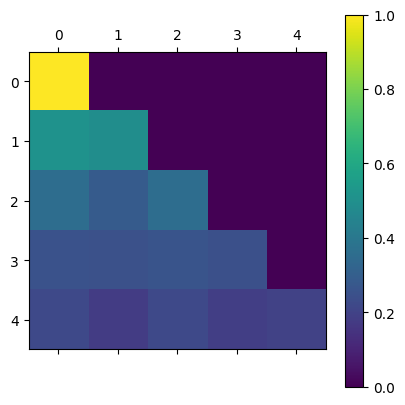

In [ ]:
fig = plt.figure(figsize=(10, 10))
num = att.squeeze().detach().numpy()
plt.matshow(num, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
qkv_proj = torch.nn.Linear(8, 24)

qry, key, val = qkv_proj(x).split(8, dim=-1)

# qkv -> (1, 5, 8 * 3) -> (1, 5, 24)
# qry -> qkv.split(..) -> (1, 5,  8)
# key -> qkv.split(..) -> (1, 5,  8)
# val -> qkv.split(..) -> (1, 5,  8)

att = qry @ key.transpose(-1, -2) / math.sqrt(8)
msk = torch.tril(torch.ones(5, 5)) == 0
att = att.masked_fill(msk, -float('inf'))
att = torch.softmax(att, dim=-1)
out = att @ val

<Figure size 1000x1000 with 0 Axes>

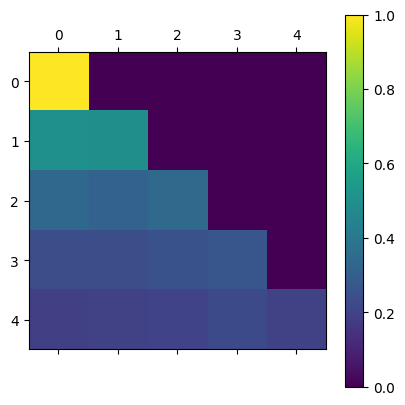

In [ ]:
fig = plt.figure(figsize=(10, 10))
num = att.squeeze().detach().numpy()
plt.matshow(num, cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
qkv_proj = torch.nn.Linear(8, 24)
qry, key, val = qkv_proj(x).split(8, dim=-1)
out = torch.nn.functional.scaled_dot_product_attention(qry, key, val, is_causal=True)
#previous graphs plotted att, we don't have access to it as it is within the sdpa in-built torch function

In [ ]:
qkv_proj = torch.nn.Linear(8, 24)
qry, key, val = qkv_proj(x).split(8, dim=-1)

# Given the embedding of size 8, we want
# to split it and send it to different
# heads to compute a "partial" attention.
#
# Practically, the starting point is:
#
# qry -> (1, 5, 8)
# key -> (1, 5, 8)
# val -> (1, 5, 8)
#
# For each token we enhanced the embedding
# with the Linear layer. Now we want to split
# it again, 4 elements to each head.
#
# qry -> (1, 5, 2, 4)
# key -> (1, 5, 2, 4)
# val -> (1, 5, 2, 4)
#
# Multiplying the queries with the keys in
# this shape directly would not make sense.
# Stop and think about it, you will notice
# that we would multiply the same token query
# with the same token key. See the output:
#
# (1, 5, 2, 4) @ (1, 5, 4, 2) -> (1, 5, 2, 2)
#
# It could be read as: For each token we have
# an attention matrix of shape (2, 2) as the
# result of ones token query multiplied by the
# same token key.
#
# What we want instead is: For each head there
# is an attention matrix between the tokens with
# respective queries and keys.
#
# (1, ?, ?, ?) @ (1, ?, ?, ?) -> (1, 2, 5, 5)
#
# The aim is to group all the token queries
# for each head, then do the same for the keys.
#
# qry -> (1, 5, 2, 4) -> (1, 2, 5, 4)
# key -> (1, 5, 2, 4) -> (1, 2, 5, 4)
#
# To phrase it out loud: For each head group
# all the tokens queries and keys. Computing
# attention now is straight forward:
#
# qry @ key.transpose(-1, -2) -> (1, 2, 5, 5)
#
# From here on is the same as normal attention,
# with some minor changes to accommodate for the
# value shape concatenation.

qry = qry.reshape(1, 5, 2, 4).transpose(1, 2)      # (1, 5, 8) -> (1, 5, 2, 4) -> (1, 2, 5, 4)
key = key.reshape(1, 5, 2, 4).transpose(1, 2)      # (1, 5, 8) -> (1, 5, 2, 4) -> (1, 2, 5, 4)
val = val.reshape(1, 5, 2, 4).transpose(1, 2)      # (1, 5, 8) -> (1, 5, 2, 4) -> (1, 2, 5, 4)

att = qry @ key.transpose(-1, -2) / math.sqrt(4)   # (1, 2, 5, 5)
out = (att @ val).transpose(1, 2).reshape(1, 5, 8) # (1, 2, 5, 4) -> (1, 5, 2, 4) -> (1, 5, 8)

#Multi-head cleaned up

In [ ]:
qkv_proj = torch.nn.Linear(8, 24)
qry, key, val = qkv_proj(x).split(8, dim=-1)

qry = qry.reshape(1, 5, 2, 4).transpose(1, 2)      # (1, 5, 8) -> (1, 5, 2, 4) -> (1, 2, 5, 4)
key = key.reshape(1, 5, 2, 4).transpose(1, 2)      # (1, 5, 8) -> (1, 5, 2, 4) -> (1, 2, 5, 4)
val = val.reshape(1, 5, 2, 4).transpose(1, 2)      # (1, 5, 8) -> (1, 5, 2, 4) -> (1, 2, 5, 4)

att = qry @ key.transpose(-1, -2) / math.sqrt(4)   # (1, 2, 5, 5)
out = (att @ val).transpose(1, 2).reshape(1, 5, 8) # (1, 2, 5, 4) -> (1, 5, 2, 4) -> (1, 5, 8)

In [ ]:
# import torch
# import torch.nn as nn

# class MultiHeadedAttention(nn.Module):

#     def __init__(self, embed_dim, num_heads, dropout):
#         super().__init__()

#         self.embed_dim = embed_dim
#         self.num_heads = num_heads
#         self.head_dim = embed_dim // num_heads

#         self.q_proj = nn.Linear(embed_dim, embed_dim)
#         self.k_proj = nn.Linear(embed_dim, embed_dim)
#         self.v_proj = nn.Linear(embed_dim, embed_dim)


#         out = torch.nn.functional.scaled_dot_product_attention(qry, key, val, is_causal=True)

#         self.out_proj = nn.Linear(embed_dim, embed_dim)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, query, key, value, attn_mask):

#         # Retain shape after projection
#         query = self.q_proj(query)
#         key = self.k_proj(key)
#         value = self.v_proj(value)

#         qry, key, val = qkv_proj(x).split(self.num.heads, dim=-1)

#         qry = qry.reshape(1, 5, 2, 4).transpose(1, 2)      # (1, 5, 8) -> (1, 5, 2, 4) -> (1, 2, 5, 4)
#         key = key.reshape(1, 5, 2, 4).transpose(1, 2)      # (1, 5, 8) -> (1, 5, 2, 4) -> (1, 2, 5, 4)
#         val = val.reshape(1, 5, 2, 4).transpose(1, 2)      # (1, 5, 8) -> (1, 5, 2, 4) -> (1, 2, 5, 4)

#         att = qry @ key.transpose(-1, -2) / math.sqrt(4)   # (1, 2, 5, 5)
#         out = (att @ val).transpose(1, 2).reshape(1, 5, 8) # (1, 2, 5, 4) -> (1, 5, 2, 4) -> (1, 5, 8)

#         attn_out = self.out_proj(output)

#         return attn_out